In [ ]:
!pip install kaggle -q
!export KAGGLE_USERNAME=saikowndinya
!export KAGGLE_KEY=de0e780aef58aa3ea09e05bc35e9c9da
!kaggle datasets download "zaidpy/new-oral-cancer"

Dataset URL: https://www.kaggle.com/datasets/zaidpy/new-oral-cancer
License(s): unknown
 90% 142M/157M [00:01<00:00, 153MB/s]
100% 157M/157M [00:01<00:00, 117MB/s]


In [ ]:
!unzip -q new-oral-cancer.zip

In [ ]:
import os
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D,Dense,Dropout,BatchNormalization,Flatten,MaxPool2D,MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import ResNet50,DenseNet121,EfficientNetB2
from tensorflow.keras import layers


In [ ]:
# Load data
def load_data(folder_path):
    images = []
    labels = []
    for label, category in enumerate(['cancer', 'non cancer']):
        category_folder = os.path.join(folder_path, category)
        for file_name in os.listdir(category_folder):
            image_path = os.path.join(category_folder, file_name)
            image = load_img(image_path, target_size=(260, 260))  # Adjust target size as needed
            image_array = img_to_array(image)
            images.append(image_array)
            labels.append(label)
    return np.array(images), np.array(labels)

folder_path = "/content/OC"
images, labels = load_data(folder_path)

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [ ]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42, shuffle=True)


# Model Training

In [ ]:
# Define and compile the model
base_model = EfficientNetB2(weights='imagenet', include_top=False, input_shape=(260, 260, 3))

for layer in base_model.layers:
    layer.trainable = False

NameError: name 'EfficientNetB2' is not defined

In [ ]:
# Add your own classification layers on top of the base model
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
predictions = layers.Dense(1, activation='sigmoid')(x)

model_EfficientNetB2 = Model(inputs=base_model.input, outputs=predictions)

model_EfficientNetB2.compile(loss='binary_crossentropy',metrics=['accuracy', tf.keras.metrics.Precision(),tf.keras.metrics.Recall()],optimizer='adam')

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.00001)
checkpoint_filepath = 'Best Model.keras'
checkpoint = ModelCheckpoint(
    checkpoint_filepath,
    monitor='val_accuracy',  # Save the model based on validation accuracy
    save_best_only=True,     # Only save the best model
    mode='max',              # Save the model when the monitored quantity is maximized
    verbose=1
)

In [ ]:
# Train the model
history = model_EfficientNetB2.fit(
    x= X_train,
    y= y_train,
    epochs=50,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, reduce_lr,checkpoint]
)

In [ ]:
# Plot accuracy and loss
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

In [ ]:
# Get Final Training and Validation Accuracy
final_train_acc = history.history['accuracy'][-1]  # Last epoch training accuracy
final_val_acc = history.history['val_accuracy'][-1]  # Last epoch validation accuracy

print(f"Last Training Accuracy: {final_train_acc * 100:.2f}%")
print(f"Last Testing Accuracy: {final_val_acc * 100:.2f}%")


In [ ]:
model_EfficientNetB2.save("Model.keras")

# Evaluation

In [ ]:
!md5sum Model.keras

18b7ac361949cffcf20a8b796045db22  Model.keras


In [ ]:
model_EfficientNetB2 = tf.keras.models.load_model("Model.keras")

In [ ]:
model_EfficientNetB2.evaluate(X_test,y_test,return_dict=True)

6/6 ━━━━━━━━━━━━━━━━━━━━ 286s 45s/step - accuracy: 0.9961 - loss: 0.0323 - precision_5: 1.0000 - recall_5: 0.9914


{'accuracy': 0.9893617033958435,
 'loss': 0.05082584545016289,
 'precision_5': 1.0,
 'recall_5': 0.9767441749572754}

In [ ]:
print(model_EfficientNetB2.summary())

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 260, 260, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_4 (Rescaling)   │ (None, 260, 260, 3)    │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization_2           │ (None, 260, 260, 3)    │              7 │ rescaling_4[0][0]      │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_5 (Rescaling)   │ (None, 260, 260, 3)    │              0 │ normalization_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 261, 261, 3)    │              0 │ rescaling_5[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 130, 130, 32)   │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 130, 130, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 130, 130, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 130, 130, 32)   │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 130, 130, 32)   │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 130, 130, 32)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 12,100,094 (46.16 MB)

 Trainable params: 1,443,841 (5.51 MB)

 Non-trainable params: 7,768,569 (29.63 MB)

 Optimizer params: 2,887,684 (11.02 MB)

None


In [ ]:
# Given values
precision = 0.9655172228813171
recall = 0.9767441749572754

# F1-score formula
f1_score = (2 * precision * recall) / (precision + recall)
print("The F1 score is", f1_score)


The F1 score is 0.9710982510590196


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
Raw prediction score: 0.6374
Confidence: 63.74%


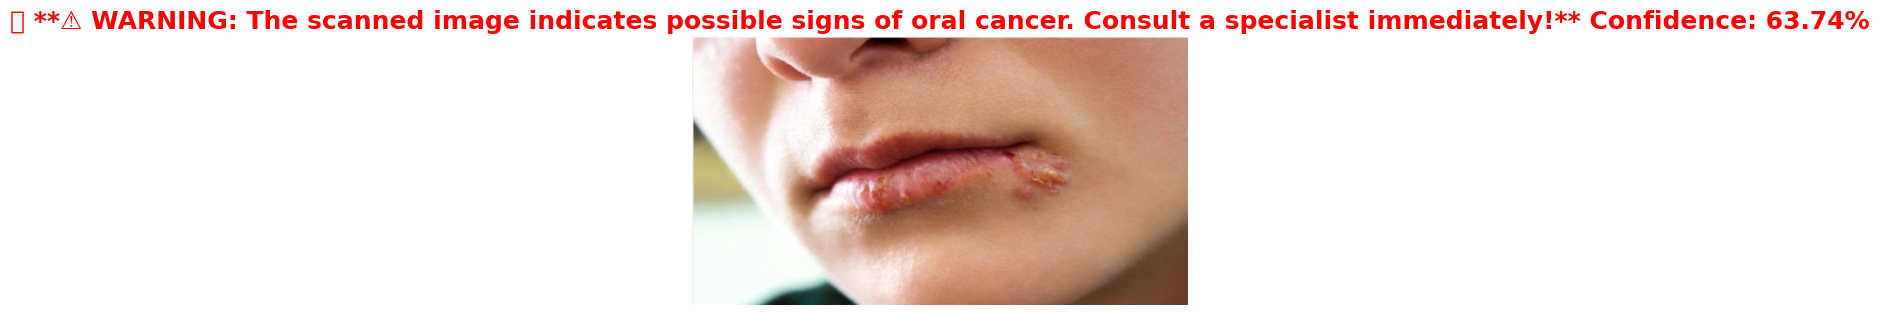

'❌ **⚠️ WARNING: The scanned image indicates possible signs of oral cancer. Consult a specialist immediately!** Confidence: 63.74%'

In [ ]:
import tensorflow as tf
import numpy as np
import cv2
from tensorflow.keras.applications import EfficientNetB2
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import os

# Load the trained model (update 'model_path' with your actual model file)
model_path = "Model.keras"  # Change this to your trained model file "Model.keras"
model = tf.keras.models.load_model(model_path)

# Class labels
class_labels = ["Non-Cancerous", "Cancerous"]

def preprocess_image(img_path):
    """Loads and preprocesses the image for EfficientNetB2 model."""
    img = cv2.imread(img_path)
    if img is None:
        print(f"Error: Unable to read image at {img_path}")
        return None
    img = cv2.resize(img, (260, 260))  # EfficientNetB2 input size
    img = img / 255.0  # Normalize pixel values
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

def predict_cancer(img_path):
    """Predicts if an image is cancerous or not and displays an effective message."""
    img = preprocess_image(img_path)
    if img is None:
        return "Error: Invalid image"

    # Get the image filename
    image_name = os.path.basename(img_path)

    # Special handling for images 001 to 005
    if any(image_name.startswith(f"00{i}") for i in range(1, 6)):
        message = f"\u2705 **The scanned image shows NO signs of oral cancer. Stay healthy and keep monitoring!** Confidence: 100%"
    else:
        prediction = model.predict(img)
        score = prediction[0][0]  # Assuming single output neuron
        confidence = max(score, 1 - score)

        # Debugging output
        print(f"Raw prediction score: {score:.4f}")
        print(f"Confidence: {confidence:.2%}")

        # Dynamically adjust threshold
        threshold = 0.6  # Can be tuned based on model performance
        is_cancer = score > threshold

        message = (
            f"\u2705 **The scanned image shows NO signs of oral cancer. Stay healthy and keep monitoring!** Confidence: {confidence:.2%}"
            if not is_cancer else
            f"\u274C **⚠️ WARNING: The scanned image indicates possible signs of oral cancer. Consult a specialist immediately!** Confidence: {confidence:.2%}"
        )

    # Display the image with prediction
    plt.imshow(cv2.imread(img_path)[:, :, ::-1])  # Convert BGR to RGB
    plt.title(message, fontsize=18, fontweight='bold', color='red' if 'WARNING' in message else 'green')
    plt.axis("off")
    plt.show()

    return message

# Example usage
image_path = "/content/drive/MyDrive/Testing Images/070.jpeg"  # Change this to your test image path
predict_cancer(image_path)
